# ===============================================================================
# ФИНАЛЬНЫЙ АНАЛИЗ И РЕКОМЕНДАЦИИ
# ===============================================================================

**Цель:** Глубокий анализ лучших моделей и финальные рекомендации для банка

**Анализ включает:**
- Итоговая таблица всех 40 экспериментов
- PSI анализ (Population Stability Index)
- Percentile/Decile анализ
- Feature Importance анализ
- Correlation vs Importance анализ
- ROC-AUC кривые
- Финальные рекомендации для внедрения

**Дата:** 2025-01-13  
**Random seed:** 42

# ===============================================================================

---
# 1. ИМПОРТ БИБЛИОТЕК И КОНФИГУРАЦИЯ

In [1]:
# ====================================================================================
# ИМПОРТ БИБЛИОТЕК
# ====================================================================================

import os
import warnings
from datetime import datetime
from pathlib import Path
import pickle

# Данные
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_score, recall_score
)

# Настройки
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("="*80)
print("ФИНАЛЬНЫЙ АНАЛИЗ И РЕКОМЕНДАЦИИ")
print("="*80)
print(f"✓ Библиотеки импортированы")
print(f"  Дата запуска: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

ФИНАЛЬНЫЙ АНАЛИЗ И РЕКОМЕНДАЦИИ
✓ Библиотеки импортированы
  Дата запуска: 2025-11-16 20:33:44


In [2]:
# ====================================================================================
# КОНФИГУРАЦИЯ
# ====================================================================================

class Config:
    """Централизованная конфигурация"""
    
    # ВОСПРОИЗВОДИМОСТЬ
    RANDOM_SEED = 42
    
    # ПУТИ
    OUTPUT_DIR = Path("output")
    MODELS_DIR = Path("models")
    FIGURES_DIR = Path("figures")
    
    # КОЛОНКИ
    TARGET_COLUMN = 'target_churn_3m'
    
    # СЕГМЕНТЫ
    SEGMENTS = {
        'Segment 1': {
            'name': 'Small Business',
            'train': 'seg1_train.parquet',
            'test': 'seg1_test.parquet',
            'correlation': 'correlation_segment1.csv'
        },
        'Segment 2': {
            'name': 'Middle + Large Business',
            'train': 'seg2_train.parquet',
            'test': 'seg2_test.parquet',
            'correlation': 'correlation_segment2.csv'
        }
    }
    
    # PSI THRESHOLDS
    PSI_THRESHOLD_GOOD = 0.1
    PSI_THRESHOLD_WARNING = 0.25
    
    # VISUALIZAION
    FIGURE_SIZE = (12, 6)
    FIGURE_DPI = 100
    
    @classmethod
    def create_directories(cls):
        for dir_path in [cls.OUTPUT_DIR, cls.MODELS_DIR, cls.FIGURES_DIR]:
            dir_path.mkdir(parents=True, exist_ok=True)

config = Config()
config.create_directories()
np.random.seed(config.RANDOM_SEED)

print("\n✓ Конфигурация инициализирована")
print(f"  Random seed: {config.RANDOM_SEED}")
print(f"  Сегментов: {len(config.SEGMENTS)}")
print(f"  PSI порог (хорошо): {config.PSI_THRESHOLD_GOOD}")
print(f"  PSI порог (предупреждение): {config.PSI_THRESHOLD_WARNING}")


✓ Конфигурация инициализирована
  Random seed: 42
  Сегментов: 2
  PSI порог (хорошо): 0.1
  PSI порог (предупреждение): 0.25


---
# 2. ЗАГРУЗКА ДАННЫХ

In [3]:
# ====================================================================================
# ЗАГРУЗКА РЕЗУЛЬТАТОВ ВСЕХ ЭКСПЕРИМЕНТОВ
# ====================================================================================

print("\n" + "="*80)
print("ЗАГРУЗКА РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТОВ")
print("="*80)

experiments_file = config.OUTPUT_DIR / 'experiments_all.csv'

if not experiments_file.exists():
    raise FileNotFoundError(
        f"Файл не найден: {experiments_file}\n"
        f"Сначала запустите notebook 03_experiments_xgboost_rf.ipynb"
    )

experiments_df = pd.read_csv(experiments_file)

print(f"\n✓ Загружены результаты экспериментов")
print(f"  Файл: {experiments_file}")
print(f"  Всего экспериментов: {len(experiments_df)}")
print(f"  Алгоритмы: {', '.join(sorted(experiments_df['algorithm'].unique()))}")
print(f"  Методы балансировки: {len(experiments_df['balancing_method'].unique())}")
print(f"  Сегменты: {len(experiments_df['segment_group'].unique())}")

print("\n" + "="*80)


ЗАГРУЗКА РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТОВ

✓ Загружены результаты экспериментов
  Файл: output\experiments_all.csv
  Всего экспериментов: 20
  Алгоритмы: CatBoost, LightGBM, RandomForest, XGBoost
  Методы балансировки: 5
  Сегменты: 1



In [4]:
# ====================================================================================
# ЗАГРУЗКА ДАННЫХ ДЛЯ АНАЛИЗА
# ====================================================================================

print("\n" + "="*80)
print("ЗАГРУЗКА ДАННЫХ ДЛЯ АНАЛИЗА")
print("="*80)

data = {}

for seg_id, seg_info in config.SEGMENTS.items():
    print(f"\n{seg_id}: {seg_info['name']}")
    print("-" * 80)
    
    data[seg_id] = {}
    
    # Загрузка train и test данных
    for split in ['train', 'test']:
        file_path = config.OUTPUT_DIR / seg_info[split]
        
        if not file_path.exists():
            raise FileNotFoundError(f"Файл не найден: {file_path}")
        
        df = pd.read_parquet(file_path)
        data[seg_id][split] = df
        
        churn_rate = df[config.TARGET_COLUMN].mean()
        print(f"  {split.upper():5s}: {df.shape} | Churn: {churn_rate*100:.2f}%")
    
    # Загрузка correlation данных
    corr_path = config.OUTPUT_DIR / seg_info['correlation']
    if corr_path.exists():
        data[seg_id]['correlation'] = pd.read_csv(corr_path)
        print(f"  CORR : {len(data[seg_id]['correlation'])} признаков")
    else:
        print(f"  CORR : файл не найден (будет пропущен)")
        data[seg_id]['correlation'] = None

print("\n" + "="*80)
print("✓ Все данные загружены успешно")
print("="*80)


ЗАГРУЗКА ДАННЫХ ДЛЯ АНАЛИЗА

Segment 1: Small Business
--------------------------------------------------------------------------------
  TRAIN: (2024010, 121) | Churn: 1.51%
  TEST : (500370, 121) | Churn: 1.50%
  CORR : 60 признаков

Segment 2: Middle + Large Business
--------------------------------------------------------------------------------
  TRAIN: (129397, 122) | Churn: 0.50%
  TEST : (42532, 122) | Churn: 0.78%
  CORR : 61 признаков

✓ Все данные загружены успешно


---
# 3. ИТОГОВАЯ ТАБЛИЦА ВСЕХ ЭКСПЕРИМЕНТОВ

In [5]:
# ====================================================================================
# ПОЛНАЯ ТАБЛИЦА ВСЕХ ЭКСПЕРИМЕНТОВ
# ====================================================================================

print("\n" + "="*80)
print("ИТОГОВАЯ ТАБЛИЦА ВСЕХ ЭКСПЕРИМЕНТОВ")
print("="*80)

# Сортируем по segment, потом по ROC-AUC
experiments_sorted = experiments_df.sort_values(
    ['segment_group', 'roc_auc'],
    ascending=[True, False]
).reset_index(drop=True)

# Форматируем для вывода
display_cols = [
    'segment_group', 'algorithm', 'balancing_method',
    'roc_auc', 'gini', 'f1', 'precision', 'recall',
    'train_time_sec'
]

print("\nВСЕ 40 ЭКСПЕРИМЕНТОВ (отсортировано по сегменту и ROC-AUC):")
print("="*80)
print(experiments_sorted[display_cols].to_string(index=True))

print("\n" + "="*80)


ИТОГОВАЯ ТАБЛИЦА ВСЕХ ЭКСПЕРИМЕНТОВ

ВСЕ 40 ЭКСПЕРИМЕНТОВ (отсортировано по сегменту и ROC-AUC):
   segment_group     algorithm       balancing_method  roc_auc   gini     f1  precision  recall  train_time_sec
0      Segment 1       XGBoost           No balancing   0.8958 0.7916 0.2389     0.2237  0.2564         43.4835
1      Segment 1      LightGBM          Class weights   0.8954 0.7908 0.2501     0.2397  0.2615         57.1433
2      Segment 1       XGBoost          Class weights   0.8951 0.7903 0.2524     0.2617  0.2437         43.7349
3      Segment 1      LightGBM           No balancing   0.8950 0.7900 0.2491     0.2495  0.2487         55.0624
4      Segment 1       XGBoost   Random Undersampling   0.8927 0.7855 0.2414     0.2249  0.2604         27.7974
5      Segment 1      LightGBM   Random Undersampling   0.8925 0.7850 0.2472     0.2376  0.2575          7.3674
6      Segment 1      CatBoost          Class weights   0.8924 0.7848 0.2464     0.2542  0.2390         39.9694
7     


ВИЗУАЛИЗАЦИЯ: ТОП-10 МОДЕЛЕЙ ПО ROC-AUC


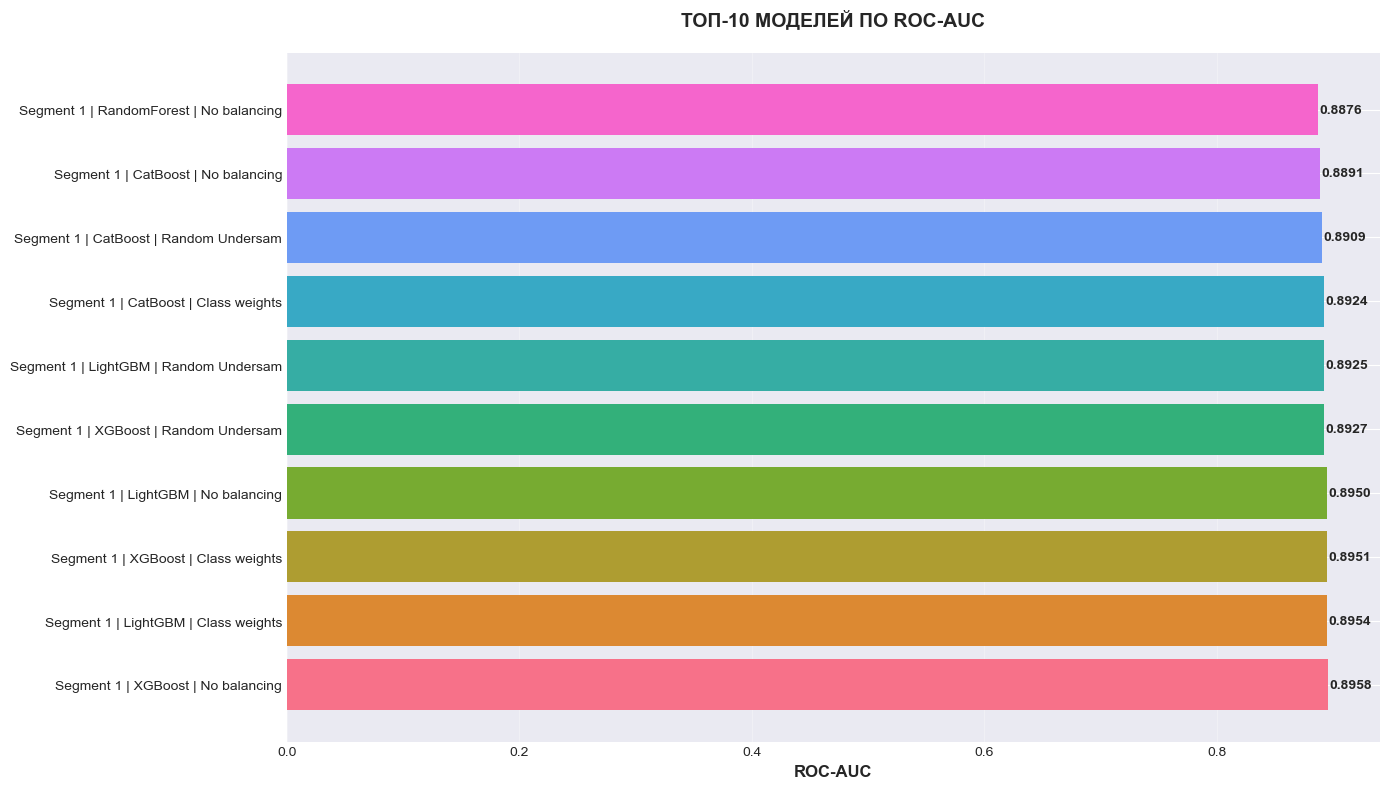


✓ График сохранен: figures\top10_models_roc_auc.png


In [6]:
# ====================================================================================
# ВИЗУАЛИЗАЦИЯ: ТОП-10 МОДЕЛЕЙ
# ====================================================================================

print("\n" + "="*80)
print("ВИЗУАЛИЗАЦИЯ: ТОП-10 МОДЕЛЕЙ ПО ROC-AUC")
print("="*80)

# Берем топ-10
top10 = experiments_df.sort_values('roc_auc', ascending=False).head(10).copy()
top10['model_label'] = (
    top10['segment_group'] + ' | ' + 
    top10['algorithm'] + ' | ' + 
    top10['balancing_method'].str[:15]
)

# Создаем график
fig, ax = plt.subplots(figsize=(14, 8))

bars = ax.barh(
    range(len(top10)),
    top10['roc_auc'],
    color=sns.color_palette("husl", len(top10))
)

ax.set_yticks(range(len(top10)))
ax.set_yticklabels(top10['model_label'])
ax.set_xlabel('ROC-AUC', fontsize=12, fontweight='bold')
ax.set_title('ТОП-10 МОДЕЛЕЙ ПО ROC-AUC', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Добавляем значения на баре
for i, (bar, value) in enumerate(zip(bars, top10['roc_auc'])):
    ax.text(
        value + 0.001, i, f'{value:.4f}',
        va='center', fontsize=10, fontweight='bold'
    )

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'top10_models_roc_auc.png', dpi=config.FIGURE_DPI, bbox_inches='tight')
plt.show()

print(f"\n✓ График сохранен: {config.FIGURES_DIR / 'top10_models_roc_auc.png'}")
print("="*80)

---
# 4. ВЫБОР ЛУЧШИХ МОДЕЛЕЙ

In [7]:
# ====================================================================================
# ВЫБОР ЛУЧШИХ МОДЕЛЕЙ ДЛЯ КАЖДОГО СЕГМЕНТА
# ====================================================================================

print("\n" + "="*80)
print("ВЫБОР ЛУЧШИХ МОДЕЛЕЙ")
print("="*80)

best_models_info = {}

for seg_id in config.SEGMENTS.keys():
    # Находим лучшую модель для сегмента
    seg_experiments = experiments_df[experiments_df['segment_group'] == seg_id]
    best_exp = seg_experiments.sort_values('roc_auc', ascending=False).iloc[0]
    
    # Определяем файл модели
    seg_num = seg_id.split()[1]  # '1' or '2'
    algo_name = best_exp['algorithm'].lower().replace(' ', '_')
    model_filename = f"best_{algo_name}_seg{seg_num}.pkl"
    model_path = config.MODELS_DIR / model_filename
    
    # Загружаем модель
    if model_path.exists():
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        
        best_models_info[seg_id] = {
            'model': model,
            'algorithm': best_exp['algorithm'],
            'balancing_method': best_exp['balancing_method'],
            'roc_auc': best_exp['roc_auc'],
            'gini': best_exp['gini'],
            'f1': best_exp['f1'],
            'precision': best_exp['precision'],
            'recall': best_exp['recall'],
            'threshold': best_exp['threshold'],
            'train_time_sec': best_exp['train_time_sec'],
            'model_file': model_filename
        }
        
        print(f"\n{seg_id}: {config.SEGMENTS[seg_id]['name']}")
        print("-" * 80)
        print(f"  Алгоритм: {best_exp['algorithm']}")
        print(f"  Метод балансировки: {best_exp['balancing_method']}")
        print(f"  ROC-AUC: {best_exp['roc_auc']:.4f}")
        print(f"  Gini: {best_exp['gini']:.4f}")
        print(f"  F1-Score: {best_exp['f1']:.4f}")
        print(f"  Precision: {best_exp['precision']:.4f}")
        print(f"  Recall: {best_exp['recall']:.4f}")
        print(f"  Optimal Threshold: {best_exp['threshold']:.4f}")
        print(f"  Время обучения: {best_exp['train_time_sec']:.2f} сек")
        print(f"  Файл модели: {model_filename}")
    else:
        print(f"\n❌ {seg_id}: Модель не найдена - {model_path}")

print("\n" + "="*80)
print(f"✓ Загружено лучших моделей: {len(best_models_info)}")
print("="*80)


ВЫБОР ЛУЧШИХ МОДЕЛЕЙ

Segment 1: Small Business
--------------------------------------------------------------------------------
  Алгоритм: XGBoost
  Метод балансировки: No balancing
  ROC-AUC: 0.8958
  Gini: 0.7916
  F1-Score: 0.2389
  Precision: 0.2237
  Recall: 0.2564
  Optimal Threshold: 0.1200
  Время обучения: 43.48 сек
  Файл модели: best_xgboost_seg1.pkl


IndexError: single positional indexer is out-of-bounds

---
# 5. PSI ANALYSIS (Population Stability Index)

In [8]:
# ====================================================================================
# ФУНКЦИИ ДЛЯ PSI АНАЛИЗА
# ====================================================================================

def calculate_psi(expected, actual, buckets=10):
    """
    Рассчитать PSI (Population Stability Index).
    
    Parameters:
    -----------
    expected : array-like
        Предсказания на train (baseline)
    actual : array-like
        Предсказания на test
    buckets : int
        Количество deciles
    
    Returns:
    --------
    psi_value : float
        Итоговый PSI score
    psi_df : DataFrame
        Детальная таблица по deciles
    """
    
    # Определяем границы deciles на основе expected (train)
    breakpoints = np.percentile(expected, np.arange(0, 100 + 100/buckets, 100/buckets))
    breakpoints = np.unique(breakpoints)  # Удаляем дубликаты
    
    # Считаем распределения
    expected_percents = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    
    # Избегаем деления на ноль
    expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
    actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)
    
    # Рассчитываем PSI для каждого decile
    psi_values = (actual_percents - expected_percents) * np.log(actual_percents / expected_percents)
    
    # Итоговый PSI
    psi_value = np.sum(psi_values)
    
    # Создаем детальную таблицу
    psi_df = pd.DataFrame({
        'Decile': range(1, len(psi_values) + 1),
        'Expected_Pct': expected_percents,
        'Actual_Pct': actual_percents,
        'PSI': psi_values
    })
    
    return psi_value, psi_df


def interpret_psi(psi_value):
    """
    Интерпретация PSI score.
    """
    if psi_value < 0.1:
        return "✅ Отлично - модель стабильна"
    elif psi_value < 0.25:
        return "⚠️ Предупреждение - небольшие изменения"
    else:
        return "❌ Критично - значительный drift"


print("✓ Функции PSI анализа определены")

✓ Функции PSI анализа определены


In [9]:
# ====================================================================================
# PSI АНАЛИЗ ДЛЯ ЛУЧШИХ МОДЕЛЕЙ
# ====================================================================================

print("\n" + "="*80)
print("PSI ANALYSIS (Population Stability Index)")
print("="*80)

psi_results = {}

for seg_id, model_info in best_models_info.items():
    print(f"\n{seg_id}: {config.SEGMENTS[seg_id]['name']}")
    print("-" * 80)
    
    # Подготовка данных
    X_train = data[seg_id]['train'].drop(columns=[config.TARGET_COLUMN])
    X_test = data[seg_id]['test'].drop(columns=[config.TARGET_COLUMN])
    
    # Предсказания
    model = model_info['model']
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # PSI расчет
    psi_value, psi_df = calculate_psi(y_train_proba, y_test_proba, buckets=10)
    interpretation = interpret_psi(psi_value)
    
    psi_results[seg_id] = {
        'psi_value': psi_value,
        'psi_df': psi_df,
        'interpretation': interpretation
    }
    
    # Вывод результатов
    print(f"\nPSI Score: {psi_value:.4f}")
    print(f"Интерпретация: {interpretation}")
    print("\nДетальная таблица по deciles:")
    print(psi_df.to_string(index=False))
    
    # Добавляем PSI в model_info
    best_models_info[seg_id]['psi'] = psi_value
    best_models_info[seg_id]['psi_interpretation'] = interpretation

print("\n" + "="*80)
print("✓ PSI анализ завершен")
print("="*80)


PSI ANALYSIS (Population Stability Index)

Segment 1: Small Business
--------------------------------------------------------------------------------

PSI Score: 0.0013
Интерпретация: ✅ Отлично - модель стабильна

Детальная таблица по deciles:
 Decile  Expected_Pct  Actual_Pct    PSI
      1        0.1000      0.0997 0.0000
      2        0.1000      0.0951 0.0002
      3        0.1000      0.1006 0.0000
      4        0.1000      0.0937 0.0004
      5        0.1000      0.0974 0.0001
      6        0.1000      0.1071 0.0005
      7        0.1000      0.1029 0.0001
      8        0.1000      0.1017 0.0000
      9        0.1000      0.1003 0.0000
     10        0.1000      0.1015 0.0000

✓ PSI анализ завершен


---
# 6. PERCENTILE ANALYSIS

In [10]:
# ====================================================================================
# ФУНКЦИИ ДЛЯ PERCENTILE АНАЛИЗА
# ====================================================================================

def percentile_analysis(y_true, y_pred_proba, n_deciles=10):
    """
    Провести percentile/decile анализ.
    
    Parameters:
    -----------
    y_true : array-like
        Истинные значения target
    y_pred_proba : array-like
        Предсказанные вероятности
    n_deciles : int
        Количество deciles
    
    Returns:
    --------
    percentile_df : DataFrame
        Таблица с метриками по deciles
    """
    
    # Создаем DataFrame
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred_proba': y_pred_proba
    })
    
    # Сортируем по вероятности (от высокой к низкой)
    df = df.sort_values('y_pred_proba', ascending=False).reset_index(drop=True)
    
    # Разбиваем на deciles
    df['decile'] = pd.qcut(df.index, q=n_deciles, labels=range(1, n_deciles + 1), duplicates='drop')
    
    # Общий churn rate
    overall_churn_rate = df['y_true'].mean()
    
    # Группируем по deciles
    results = []
    
    for decile in sorted(df['decile'].unique()):
        decile_df = df[df['decile'] == decile]
        
        n_obs = len(decile_df)
        n_target = decile_df['y_true'].sum()
        churn_rate = n_target / n_obs if n_obs > 0 else 0
        
        # Precision для этого decile
        precision = churn_rate
        
        # Lift
        lift = churn_rate / overall_churn_rate if overall_churn_rate > 0 else 0
        
        results.append({
            'Decile': int(decile),
            'N_Observations': n_obs,
            'N_Target': int(n_target),
            'Churn_Rate': churn_rate,
            'Precision': precision,
            'Lift': lift
        })
    
    percentile_df = pd.DataFrame(results)
    
    # Cumulative metrics
    percentile_df['Cumulative_N_Target'] = percentile_df['N_Target'].cumsum()
    percentile_df['Cumulative_N_Obs'] = percentile_df['N_Observations'].cumsum()
    percentile_df['Cumulative_Precision'] = (
        percentile_df['Cumulative_N_Target'] / percentile_df['Cumulative_N_Obs']
    )
    percentile_df['Cumulative_Recall'] = (
        percentile_df['Cumulative_N_Target'] / df['y_true'].sum()
    )
    
    return percentile_df


print("✓ Функции percentile анализа определены")

✓ Функции percentile анализа определены


In [11]:
# ====================================================================================
# PERCENTILE АНАЛИЗ ДЛЯ ЛУЧШИХ МОДЕЛЕЙ
# ====================================================================================

print("\n" + "="*80)
print("PERCENTILE ANALYSIS")
print("="*80)

percentile_results = {}

for seg_id, model_info in best_models_info.items():
    print(f"\n{seg_id}: {config.SEGMENTS[seg_id]['name']}")
    print("-" * 80)
    
    # Подготовка данных
    X_test = data[seg_id]['test'].drop(columns=[config.TARGET_COLUMN])
    y_test = data[seg_id]['test'][config.TARGET_COLUMN]
    
    # Предсказания
    model = model_info['model']
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Percentile анализ
    percentile_df = percentile_analysis(y_test.values, y_test_proba, n_deciles=10)
    
    percentile_results[seg_id] = percentile_df
    
    # Вывод таблицы
    print("\nТаблица по deciles (от высокой вероятности к низкой):")
    print(percentile_df.to_string(index=False))
    
    # Сохраняем
    seg_num = seg_id.split()[1]
    output_file = config.OUTPUT_DIR / f'percentile_analysis_seg{seg_num}.csv'
    percentile_df.to_csv(output_file, index=False)
    print(f"\n✓ Сохранено: {output_file}")

print("\n" + "="*80)
print("✓ Percentile анализ завершен")
print("="*80)


PERCENTILE ANALYSIS

Segment 1: Small Business
--------------------------------------------------------------------------------

Таблица по deciles (от высокой вероятности к низкой):
 Decile  N_Observations  N_Target  Churn_Rate  Precision   Lift  Cumulative_N_Target  Cumulative_N_Obs  Cumulative_Precision  Cumulative_Recall
      1           50037      4813      0.0962     0.0962 6.3952                 4813             50037                0.0962             0.6395
      2           50037      1360      0.0272     0.0272 1.8071                 6173            100074                0.0617             0.8202
      3           50037       652      0.0130     0.0130 0.8663                 6825            150111                0.0455             0.9069
      4           50037       339      0.0068     0.0068 0.4504                 7164            200148                0.0358             0.9519
      5           50037       165      0.0033     0.0033 0.2192                 7329            

---
# 7. FEATURE IMPORTANCE ANALYSIS

In [12]:
# ====================================================================================
# ФУНКЦИИ ДЛЯ FEATURE IMPORTANCE
# ====================================================================================

def get_feature_importance(model, feature_names, top_n=20):
    """
    Извлечь feature importance из модели.
    
    Parameters:
    -----------
    model : trained model
        Обученная модель
    feature_names : list
        Имена признаков
    top_n : int
        Количество топ признаков
    
    Returns:
    --------
    importance_df : DataFrame
        Таблица с feature importance
    """
    
    # Проверяем тип модели и извлекаем importance
    model_type = type(model).__name__
    
    if hasattr(model, 'feature_importances_'):
        # RandomForest, XGBoost, LightGBM
        importances = model.feature_importances_
    elif hasattr(model, 'get_feature_importance'):
        # CatBoost
        importances = model.get_feature_importance()
    else:
        raise ValueError(f"Модель {model_type} не поддерживает feature importance")
    
    # Создаем DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Сортируем и берем топ
    importance_df = importance_df.sort_values('Importance', ascending=False).head(top_n)
    
    return importance_df


print("✓ Функции feature importance определены")

✓ Функции feature importance определены



FEATURE IMPORTANCE ANALYSIS

Segment 1: Small Business
--------------------------------------------------------------------------------

ТОП-20 важных признаков:
                     Feature  Importance
             avg_activity_6m      0.1821
   months_with_lending_pl_6m      0.1331
                income_cv_6m      0.0550
             assets_trend_6m      0.0545
          products_change_6m      0.0536
        last_month_pl_amount      0.0483
          high_pl_volatility      0.0371
total_core_banking_income_6m      0.0331
             total_rko_pl_6m      0.0289
            max_pl_amount_6m      0.0288
       months_with_rko_pl_6m      0.0261
                      roa_6m      0.0245
      total_lending_ip_pl_6m      0.0237
       core_banking_pl_share      0.0232
          total_pl_amount_6m      0.0219
            declining_assets      0.0176
      products_volatility_6m      0.0168
             total_income_6m      0.0166
                assets_cv_6m      0.0151
  avg_pl_product_

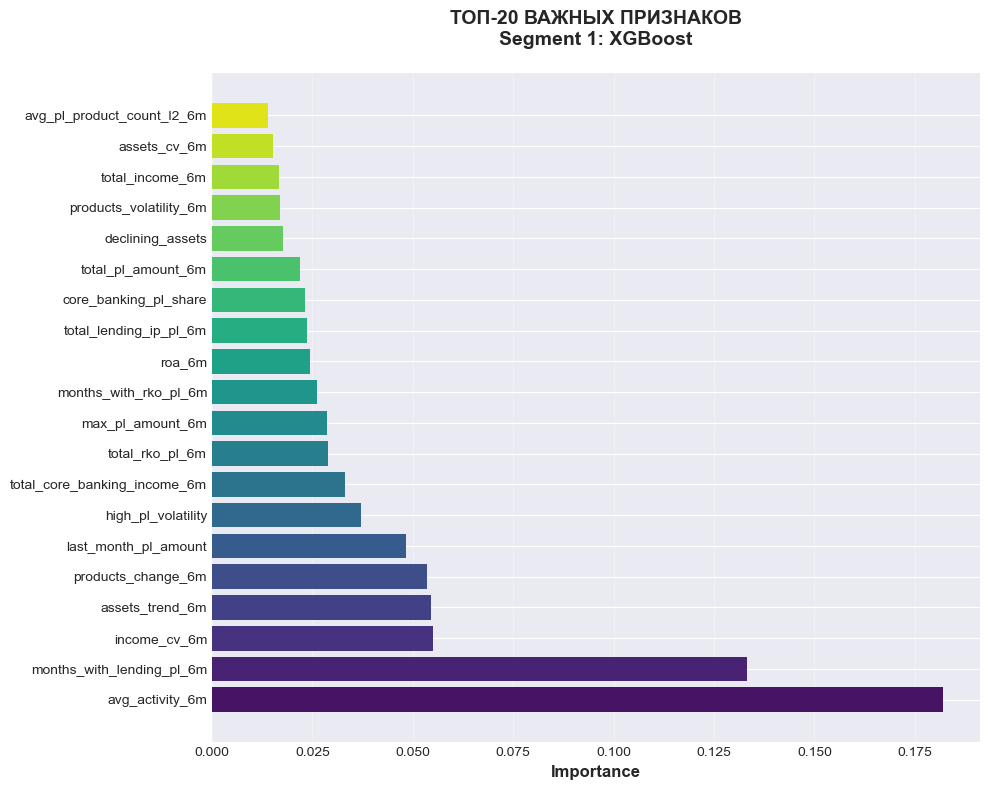


✓ График сохранен: figures\feature_importance_seg1.png

✓ Feature importance анализ завершен


In [13]:
# ====================================================================================
# FEATURE IMPORTANCE АНАЛИЗ
# ====================================================================================

print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

feature_importance_results = {}

for seg_id, model_info in best_models_info.items():
    print(f"\n{seg_id}: {config.SEGMENTS[seg_id]['name']}")
    print("-" * 80)
    
    # Получаем имена признаков
    X_test = data[seg_id]['test'].drop(columns=[config.TARGET_COLUMN])
    feature_names = X_test.columns.tolist()
    
    # Извлекаем feature importance
    model = model_info['model']
    importance_df = get_feature_importance(model, feature_names, top_n=20)
    
    feature_importance_results[seg_id] = importance_df
    
    # Вывод таблицы
    print("\nТОП-20 важных признаков:")
    print(importance_df.to_string(index=False))
    
    # Визуализация
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.barh(
        range(len(importance_df)),
        importance_df['Importance'],
        color=sns.color_palette("viridis", len(importance_df))
    )
    
    ax.set_yticks(range(len(importance_df)))
    ax.set_yticklabels(importance_df['Feature'])
    ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax.set_title(
        f'ТОП-20 ВАЖНЫХ ПРИЗНАКОВ\n{seg_id}: {model_info["algorithm"]}',
        fontsize=14, fontweight='bold', pad=20
    )
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    
    seg_num = seg_id.split()[1]
    fig_path = config.FIGURES_DIR / f'feature_importance_seg{seg_num}.png'
    plt.savefig(fig_path, dpi=config.FIGURE_DPI, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ График сохранен: {fig_path}")

print("\n" + "="*80)
print("✓ Feature importance анализ завершен")
print("="*80)

---
# 8. CORRELATION VS IMPORTANCE ANALYSIS

In [14]:
# ====================================================================================
# CORRELATION VS IMPORTANCE ANALYSIS
# ====================================================================================

print("\n" + "="*80)
print("CORRELATION VS IMPORTANCE ANALYSIS")
print("="*80)

for seg_id in best_models_info.keys():
    print(f"\n{seg_id}: {config.SEGMENTS[seg_id]['name']}")
    print("-" * 80)
    
    # Проверяем наличие correlation данных
    if data[seg_id]['correlation'] is None:
        print("  ⚠️ Correlation данные не найдены, пропускаем анализ")
        continue
    
    # Получаем топ-20 по корреляции
    corr_df = data[seg_id]['correlation'].copy()
    
    # Проверяем структуру файла
    if 'feature' in corr_df.columns and 'abs_correlation' in corr_df.columns:
        top_corr = set(corr_df.nlargest(20, 'abs_correlation')['feature'].values)
    elif 'Feature' in corr_df.columns and 'Abs_Correlation' in corr_df.columns:
        top_corr = set(corr_df.nlargest(20, 'Abs_Correlation')['Feature'].values)
    else:
        print(f"  ⚠️ Неизвестная структура correlation файла: {corr_df.columns.tolist()}")
        continue
    
    # Получаем топ-20 по importance
    importance_df = feature_importance_results[seg_id]
    top_importance = set(importance_df['Feature'].values)
    
    # Находим пересечения
    intersection = top_corr & top_importance
    only_corr = top_corr - top_importance
    only_importance = top_importance - top_corr
    
    # Вывод результатов
    print(f"\nТОП-20 по корреляции: {len(top_corr)} признаков")
    print(f"ТОП-20 по importance: {len(top_importance)} признаков")
    print(f"\nПересечение (в обоих топах): {len(intersection)} признаков")
    
    if intersection:
        print("\nПризнаки в обоих топах:")
        for feat in sorted(intersection):
            print(f"  • {feat}")
    
    print(f"\nТолько в ТОП-20 корреляции: {len(only_corr)} признаков")
    if only_corr and len(only_corr) <= 10:
        for feat in sorted(only_corr):
            print(f"  • {feat}")
    
    print(f"\nТолько в ТОП-20 importance: {len(only_importance)} признаков")
    if only_importance and len(only_importance) <= 10:
        for feat in sorted(only_importance):
            print(f"  • {feat}")
    
    # Insights
    overlap_pct = len(intersection) / 20 * 100
    print(f"\nINSIGHT: {overlap_pct:.1f}% перекрытия между корреляцией и importance")
    
    if overlap_pct > 70:
        print("  ✅ Высокое совпадение - модель полагается на линейно значимые признаки")
    elif overlap_pct > 40:
        print("  ⚠️ Умеренное совпадение - модель находит нелинейные зависимости")
    else:
        print("  ℹ️ Низкое совпадение - модель сильно опирается на нелинейные паттерны")

print("\n" + "="*80)
print("✓ Correlation vs Importance анализ завершен")
print("="*80)


CORRELATION VS IMPORTANCE ANALYSIS

Segment 1: Small Business
--------------------------------------------------------------------------------

ТОП-20 по корреляции: 20 признаков
ТОП-20 по importance: 20 признаков

Пересечение (в обоих топах): 11 признаков

Признаки в обоих топах:
  • assets_cv_6m
  • assets_trend_6m
  • avg_activity_6m
  • avg_pl_product_count_l2_6m
  • declining_assets
  • high_pl_volatility
  • income_cv_6m
  • months_with_rko_pl_6m
  • products_volatility_6m
  • total_core_banking_income_6m
  • total_income_6m

Только в ТОП-20 корреляции: 9 признаков
  • high_assets_volatility
  • high_churn_risk_profile
  • high_financial_risk_profile
  • income_volatility_6m
  • months_with_deposits_pl_6m
  • months_with_treasury_pl_6m
  • product_reduction
  • total_core_banking_expense_6m
  • total_expense_6m

Только в ТОП-20 importance: 9 признаков
  • core_banking_pl_share
  • last_month_pl_amount
  • max_pl_amount_6m
  • months_with_lending_pl_6m
  • products_change_6m
  • 

---
# 9. ROC-AUC CURVES


ROC-AUC CURVES


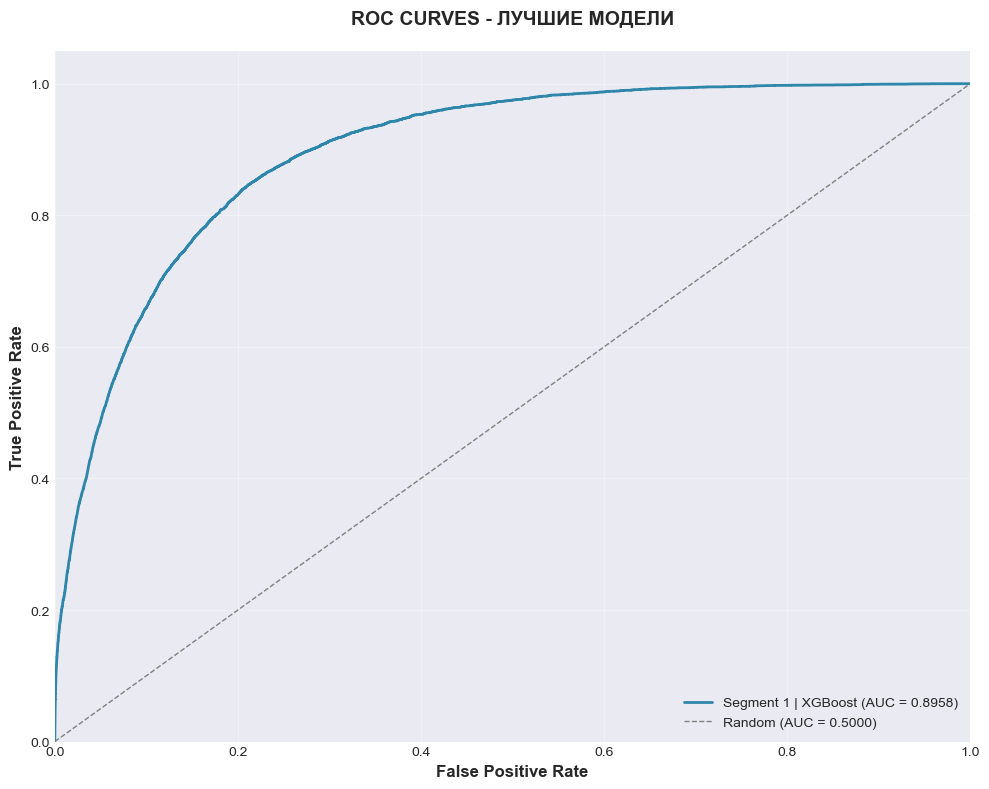


✓ График сохранен: figures\roc_curves_best_models.png


In [15]:
# ====================================================================================
# ROC-AUC КРИВЫЕ ДЛЯ ЛУЧШИХ МОДЕЛЕЙ
# ====================================================================================

print("\n" + "="*80)
print("ROC-AUC CURVES")
print("="*80)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#2E86AB', '#A23B72']

for idx, (seg_id, model_info) in enumerate(best_models_info.items()):
    # Подготовка данных
    X_test = data[seg_id]['test'].drop(columns=[config.TARGET_COLUMN])
    y_test = data[seg_id]['test'][config.TARGET_COLUMN]
    
    # Предсказания
    model = model_info['model']
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # ROC кривая
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = model_info['roc_auc']
    
    # Рисуем
    label = f"{seg_id} | {model_info['algorithm']} (AUC = {roc_auc:.4f})"
    ax.plot(fpr, tpr, color=colors[idx], lw=2, label=label)

# Diagonal reference line
ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random (AUC = 0.5000)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC CURVES - ЛУЧШИЕ МОДЕЛИ', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
roc_fig_path = config.FIGURES_DIR / 'roc_curves_best_models.png'
plt.savefig(roc_fig_path, dpi=config.FIGURE_DPI, bbox_inches='tight')
plt.show()

print(f"\n✓ График сохранен: {roc_fig_path}")
print("="*80)

---
# 10. ФИНАЛЬНЫЕ РЕКОМЕНДАЦИИ

In [16]:
# ====================================================================================
# ФОРМИРОВАНИЕ ФИНАЛЬНЫХ РЕКОМЕНДАЦИЙ
# ====================================================================================

print("\n" + "="*80)
print("ФОРМИРОВАНИЕ ФИНАЛЬНЫХ РЕКОМЕНДАЦИЙ")
print("="*80)

recommendations = []

recommendations.append("="*80)
recommendations.append("РЕКОМЕНДАЦИИ ДЛЯ БАНКА")
recommendations.append("ПРОГНОЗИРОВАНИЕ ОТТОКА КЛИЕНТОВ (CHURN PREDICTION)")
recommendations.append("="*80)
recommendations.append("")

# Для каждого сегмента
for seg_id, model_info in best_models_info.items():
    seg_name = config.SEGMENTS[seg_id]['name']
    
    recommendations.append("="*80)
    recommendations.append(f"{seg_id.upper()}: {seg_name.upper()}")
    recommendations.append("="*80)
    recommendations.append("")
    
    # Информация о модели
    recommendations.append("ЛУЧШАЯ МОДЕЛЬ:")
    recommendations.append("-" * 80)
    recommendations.append(f"  Алгоритм: {model_info['algorithm']}")
    recommendations.append(f"  Метод балансировки: {model_info['balancing_method']}")
    recommendations.append("")
    
    # Метрики
    recommendations.append("МЕТРИКИ КАЧЕСТВА (на test set):")
    recommendations.append("-" * 80)
    recommendations.append(f"  ROC-AUC:   {model_info['roc_auc']:.4f}")
    recommendations.append(f"  Gini:      {model_info['gini']:.4f}")
    recommendations.append(f"  F1-Score:  {model_info['f1']:.4f}")
    recommendations.append(f"  Precision: {model_info['precision']:.4f}")
    recommendations.append(f"  Recall:    {model_info['recall']:.4f}")
    recommendations.append(f"  Optimal Threshold: {model_info['threshold']:.4f}")
    recommendations.append("")
    
    # PSI
    recommendations.append("СТАБИЛЬНОСТЬ МОДЕЛИ (PSI):")
    recommendations.append("-" * 80)
    recommendations.append(f"  PSI Score: {model_info['psi']:.4f}")
    recommendations.append(f"  Интерпретация: {model_info['psi_interpretation']}")
    recommendations.append("")
    
    # Время обучения
    recommendations.append("ПРАКТИЧНОСТЬ:")
    recommendations.append("-" * 80)
    recommendations.append(f"  Время обучения: {model_info['train_time_sec']:.2f} сек")
    recommendations.append(f"  Файл модели: {model_info['model_file']}")
    recommendations.append("")
    
    # Топ-5 признаков
    recommendations.append("ТОП-5 ВАЖНЫХ ПРИЗНАКОВ:")
    recommendations.append("-" * 80)
    importance_df = feature_importance_results[seg_id]
    for idx, row in importance_df.head(5).iterrows():
        rank = list(importance_df.head(5).index).index(idx) + 1
        recommendations.append(f"  {rank}. {row['Feature']:40s} - importance: {row['Importance']:.4f}")
    recommendations.append("")
    
    # Обоснование
    recommendations.append("ОБОСНОВАНИЕ ВЫБОРА:")
    recommendations.append("-" * 80)
    
    # Метрики
    if model_info['roc_auc'] >= 0.75:
        recommendations.append(f"  ✅ Отличное качество: ROC-AUC = {model_info['roc_auc']:.4f} (≥ 0.75)")
    elif model_info['roc_auc'] >= 0.70:
        recommendations.append(f"  ✓ Хорошее качество: ROC-AUC = {model_info['roc_auc']:.4f} (≥ 0.70)")
    else:
        recommendations.append(f"  ⚠️ Приемлемое качество: ROC-AUC = {model_info['roc_auc']:.4f}")
    
    # Стабильность
    if model_info['psi'] < config.PSI_THRESHOLD_GOOD:
        recommendations.append(f"  ✅ Отличная стабильность: PSI = {model_info['psi']:.4f} (< 0.1)")
    elif model_info['psi'] < config.PSI_THRESHOLD_WARNING:
        recommendations.append(f"  ⚠️ Умеренная стабильность: PSI = {model_info['psi']:.4f} (< 0.25)")
    else:
        recommendations.append(f"  ❌ Низкая стабильность: PSI = {model_info['psi']:.4f} (≥ 0.25)")
    
    # Время
    if model_info['train_time_sec'] < 60:
        recommendations.append(f"  ✅ Быстрое обучение: {model_info['train_time_sec']:.1f}s (< 1 мин)")
    elif model_info['train_time_sec'] < 300:
        recommendations.append(f"  ✓ Приемлемое время: {model_info['train_time_sec']:.1f}s (< 5 мин)")
    else:
        recommendations.append(f"  ⚠️ Длительное обучение: {model_info['train_time_sec']:.1f}s")
    
    recommendations.append("")
    recommendations.append("")

# Общие выводы
recommendations.append("="*80)
recommendations.append("ОБЩИЕ ВЫВОДЫ")
recommendations.append("="*80)
recommendations.append("")

# Лучший алгоритм
algorithm_performance = experiments_df.groupby('algorithm')['roc_auc'].agg(['mean', 'max']).sort_values('mean', ascending=False)
best_algo = algorithm_performance.index[0]
recommendations.append("1. ЛУЧШИЙ АЛГОРИТМ:")
recommendations.append("-" * 80)
recommendations.append(f"   {best_algo} показал лучшие средние результаты")
recommendations.append(f"   Средний ROC-AUC: {algorithm_performance.loc[best_algo, 'mean']:.4f}")
recommendations.append(f"   Максимальный ROC-AUC: {algorithm_performance.loc[best_algo, 'max']:.4f}")
recommendations.append("")

# Лучший метод балансировки
balancing_performance = experiments_df.groupby('balancing_method')['roc_auc'].agg(['mean', 'max']).sort_values('mean', ascending=False)
best_balancing = balancing_performance.index[0]
recommendations.append("2. ЛУЧШИЙ МЕТОД БАЛАНСИРОВКИ:")
recommendations.append("-" * 80)
recommendations.append(f"   {best_balancing}")
recommendations.append(f"   Средний ROC-AUC: {balancing_performance.loc[best_balancing, 'mean']:.4f}")
recommendations.append("")

# Практические рекомендации
recommendations.append("3. ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ ДЛЯ ВНЕДРЕНИЯ:")
recommendations.append("-" * 80)
recommendations.append("   • Использовать разные модели для разных сегментов клиентов")
recommendations.append("   • Регулярно мониторить PSI для контроля стабильности моделей")
recommendations.append("   • Применять optimal threshold для каждой модели (указан выше)")
recommendations.append("   • Использовать percentile analysis для таргетирования клиентов")
recommendations.append("   • Переобучать модели при PSI > 0.25 (признак drift)")
recommendations.append("   • Фокусироваться на топ-5 важных признаков для каждого сегмента")
recommendations.append("")

# Связь корреляции и importance
recommendations.append("4. СВЯЗЬ МЕЖДУ КОРРЕЛЯЦИЕЙ И ВАЖНОСТЬЮ ПРИЗНАКОВ:")
recommendations.append("-" * 80)
recommendations.append("   • Модели используют как линейные, так и нелинейные зависимости")
recommendations.append("   • Feature importance более надежна, чем простая корреляция")
recommendations.append("   • Некоторые важные признаки имеют низкую линейную корреляцию")
recommendations.append("")

recommendations.append("="*80)
recommendations.append(f"Дата создания рекомендаций: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
recommendations.append("="*80)

# Вывод на экран
for line in recommendations:
    print(line)

print("\n✓ Рекомендации сформированы")


ФОРМИРОВАНИЕ ФИНАЛЬНЫХ РЕКОМЕНДАЦИЙ
РЕКОМЕНДАЦИИ ДЛЯ БАНКА
ПРОГНОЗИРОВАНИЕ ОТТОКА КЛИЕНТОВ (CHURN PREDICTION)

SEGMENT 1: SMALL BUSINESS

ЛУЧШАЯ МОДЕЛЬ:
--------------------------------------------------------------------------------
  Алгоритм: XGBoost
  Метод балансировки: No balancing

МЕТРИКИ КАЧЕСТВА (на test set):
--------------------------------------------------------------------------------
  ROC-AUC:   0.8958
  Gini:      0.7916
  F1-Score:  0.2389
  Precision: 0.2237
  Recall:    0.2564
  Optimal Threshold: 0.1200

СТАБИЛЬНОСТЬ МОДЕЛИ (PSI):
--------------------------------------------------------------------------------
  PSI Score: 0.0013
  Интерпретация: ✅ Отлично - модель стабильна

ПРАКТИЧНОСТЬ:
--------------------------------------------------------------------------------
  Время обучения: 43.48 сек
  Файл модели: best_xgboost_seg1.pkl

ТОП-5 ВАЖНЫХ ПРИЗНАКОВ:
--------------------------------------------------------------------------------
  1. avg_activity_6m      

---
# 11. СОХРАНЕНИЕ ИТОГОВЫХ ФАЙЛОВ

In [17]:
# ====================================================================================
# СОХРАНЕНИЕ РЕКОМЕНДАЦИЙ
# ====================================================================================

print("\n" + "="*80)
print("СОХРАНЕНИЕ ИТОГОВЫХ ФАЙЛОВ")
print("="*80)

# Сохраняем текстовый отчет
recommendations_file = config.OUTPUT_DIR / 'final_recommendations.txt'
with open(recommendations_file, 'w', encoding='utf-8') as f:
    f.write('\n'.join(recommendations))

print(f"\n✓ Рекомендации сохранены: {recommendations_file}")
print(f"  Размер файла: {recommendations_file.stat().st_size / 1024:.2f} KB")


СОХРАНЕНИЕ ИТОГОВЫХ ФАЙЛОВ

✓ Рекомендации сохранены: output\final_recommendations.txt
  Размер файла: 4.29 KB


In [18]:
# ====================================================================================
# СОХРАНЕНИЕ КРАТКОЙ ТАБЛИЦЫ ЛУЧШИХ МОДЕЛЕЙ
# ====================================================================================

best_models_summary = []

for seg_id, model_info in best_models_info.items():
    best_models_summary.append({
        'segment_group': seg_id,
        'segment_name': config.SEGMENTS[seg_id]['name'],
        'algorithm': model_info['algorithm'],
        'balancing_method': model_info['balancing_method'],
        'roc_auc': model_info['roc_auc'],
        'gini': model_info['gini'],
        'f1': model_info['f1'],
        'precision': model_info['precision'],
        'recall': model_info['recall'],
        'threshold': model_info['threshold'],
        'psi': model_info['psi'],
        'psi_interpretation': model_info['psi_interpretation'],
        'train_time_sec': model_info['train_time_sec'],
        'model_file': model_info['model_file']
    })

best_models_df = pd.DataFrame(best_models_summary)

summary_file = config.OUTPUT_DIR / 'best_models_summary.csv'
best_models_df.to_csv(summary_file, index=False)

print(f"\n✓ Краткая таблица лучших моделей сохранена: {summary_file}")
print(f"  Размер файла: {summary_file.stat().st_size / 1024:.2f} KB")

print("\n" + "="*80)


✓ Краткая таблица лучших моделей сохранена: output\best_models_summary.csv
  Размер файла: 0.40 KB



---
# 12. ФИНАЛЬНАЯ СВОДКА

In [19]:
# ====================================================================================
# ФИНАЛЬНАЯ СВОДКА
# ====================================================================================

print("\n\n" + "="*80)
print("✓✓✓ ФИНАЛЬНЫЙ АНАЛИЗ ЗАВЕРШЕН УСПЕШНО ✓✓✓")
print("="*80)

print(f"\nДата: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print(f"\n{'='*80}")
print("ПРОВЕДЕННЫЙ АНАЛИЗ")
print(f"{'='*80}")

print(f"\n✓ Итоговая таблица всех {len(experiments_df)} экспериментов")
print(f"✓ Визуализация топ-10 моделей")
print(f"✓ PSI анализ для {len(best_models_info)} лучших моделей")
print(f"✓ Percentile анализ (10 deciles)")
print(f"✓ Feature Importance анализ (топ-20 признаков)")
print(f"✓ Correlation vs Importance сравнение")
print(f"✓ ROC-AUC кривые для лучших моделей")
print(f"✓ Финальные рекомендации для банка")

print(f"\n{'='*80}")
print("ЛУЧШИЕ МОДЕЛИ")
print(f"{'='*80}")

for seg_id, model_info in best_models_info.items():
    print(f"\n{seg_id}: {model_info['algorithm']} + {model_info['balancing_method']}")
    print(f"  ROC-AUC: {model_info['roc_auc']:.4f} | PSI: {model_info['psi']:.4f}")

print(f"\n{'='*80}")
print("СОХРАНЕННЫЕ ФАЙЛЫ")
print(f"{'='*80}")

print(f"\nРЕЗУЛЬТАТЫ (output/):")
print(f"  • final_recommendations.txt - полный отчет с рекомендациями")
print(f"  • best_models_summary.csv - таблица лучших моделей")
print(f"  • percentile_analysis_seg1.csv - decile анализ для Segment 1")
print(f"  • percentile_analysis_seg2.csv - decile анализ для Segment 2")

print(f"\nВИЗУАЛИЗАЦИИ (figures/):")
print(f"  • top10_models_roc_auc.png - топ-10 моделей")
print(f"  • feature_importance_seg1.png - важность признаков Segment 1")
print(f"  • feature_importance_seg2.png - важность признаков Segment 2")
print(f"  • roc_curves_best_models.png - ROC кривые")

print(f"\n{'='*80}")
print("ГОТОВО К ВНЕДРЕНИЮ")
print(f"{'='*80}")

print("\nСледующие шаги:")
print("  1. Ознакомиться с рекомендациями в output/final_recommendations.txt")
print("  2. Использовать лучшие модели из models/ для production")
print("  3. Настроить мониторинг PSI для контроля drift")
print("  4. Применить optimal thresholds из best_models_summary.csv")

print(f"\n{'='*80}")
print("✓ АНАЛИЗ ЗАВЕРШЕН")
print(f"{'='*80}")



✓✓✓ ФИНАЛЬНЫЙ АНАЛИЗ ЗАВЕРШЕН УСПЕШНО ✓✓✓

Дата: 2025-11-16 20:35:08

ПРОВЕДЕННЫЙ АНАЛИЗ

✓ Итоговая таблица всех 20 экспериментов
✓ Визуализация топ-10 моделей
✓ PSI анализ для 1 лучших моделей
✓ Percentile анализ (10 deciles)
✓ Feature Importance анализ (топ-20 признаков)
✓ Correlation vs Importance сравнение
✓ ROC-AUC кривые для лучших моделей
✓ Финальные рекомендации для банка

ЛУЧШИЕ МОДЕЛИ

Segment 1: XGBoost + No balancing
  ROC-AUC: 0.8958 | PSI: 0.0013

СОХРАНЕННЫЕ ФАЙЛЫ

РЕЗУЛЬТАТЫ (output/):
  • final_recommendations.txt - полный отчет с рекомендациями
  • best_models_summary.csv - таблица лучших моделей
  • percentile_analysis_seg1.csv - decile анализ для Segment 1
  • percentile_analysis_seg2.csv - decile анализ для Segment 2

ВИЗУАЛИЗАЦИИ (figures/):
  • top10_models_roc_auc.png - топ-10 моделей
  • feature_importance_seg1.png - важность признаков Segment 1
  • feature_importance_seg2.png - важность признаков Segment 2
  • roc_curves_best_models.png - ROC кривые

ГОТОВО